In [1]:
#載入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#使用資料夾內鐵達尼號的資料集，練習邏輯迴歸的處理邏輯
train = pd.read_csv("data/titanic_data.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


['Age', 'Embarked']


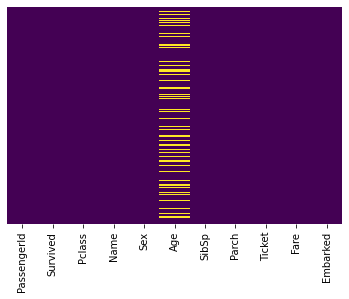

In [3]:
#探索資料
missing_columns = [i for i in train.columns if train[i].isnull().sum() != 0]
print(missing_columns)

#用heatmap(.isnull()來找出缺失的資料在哪些欄位。Age似乎約有五分之一的資料缺失，可用合理資料補充。)
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

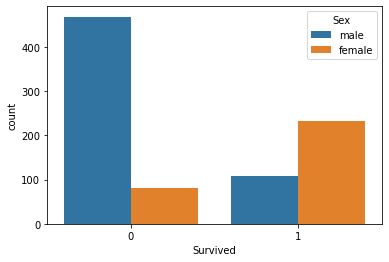

In [4]:
#用countplot來看性別是否影響最後存活。女性存活比例比男性高。
sns.countplot(x="Survived", hue="Sex", data=train)
plt.show()

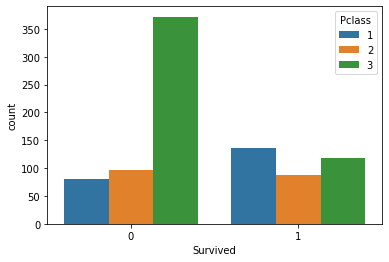

In [5]:
#艙等是否也影響存活?
sns.countplot(x="Survived", hue="Pclass", data=train)
plt.show()

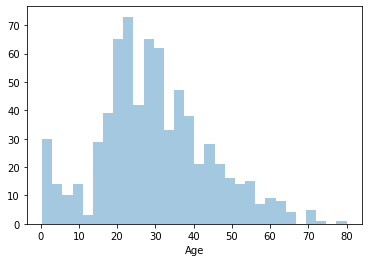

In [6]:
#用直方圖看年齡分佈。缺失資料在此不計。
sns.distplot(train["Age"].dropna(), kde=False, bins=30)
plt.show()

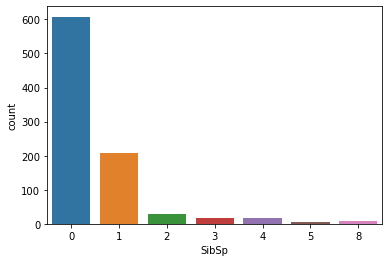

In [7]:
#SibSp代表兄弟姐妹或眷屬人數
sns.countplot(x="SibSp", data=train)
plt.show()

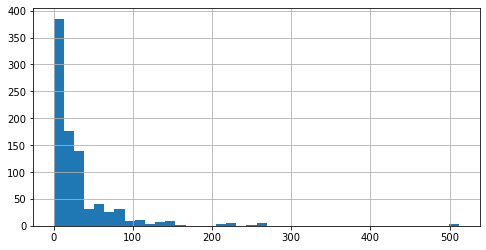

In [8]:
#用直方圖看票價分佈
train["Fare"].hist(bins=40, figsize=(8,4))
plt.show()

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64


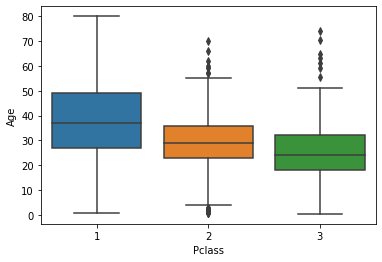

In [9]:
#資料清理
#剛有看到年齡資料約有五分之一缺失，一種做法是棄之不用，一種可以考慮把年齡平均放進去。
#使用盒鬚圖來看年齡和艙等的分佈。看起來頭等艙年齡較高，隨之降低。
age_mean_class = train.groupby("Pclass")["Age"].mean()
print(age_mean_class)
sns.boxplot(x="Pclass", y="Age", data=train)
plt.show()

In [10]:
#把艙等平均年齡填入缺失的資料中
#艙等1平均年齡是37，艙等2平均年齡是29，艙等3平均年齡是24
age_mean_dict = dict(age_mean_class)
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return age_mean_dict[1]
        elif Pclass == 2:
            return age_mean_dict[2]
        else:
            return age_mean_dict[3]
    else:
        return Age

train["Age"] = train[["Age","Pclass"]].apply(impute_age,axis=1)

['Embarked']


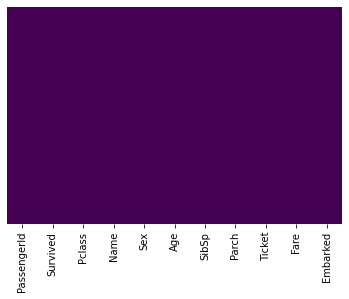

In [11]:
missing_columns = [i for i in train.columns if train[i].isnull().sum() != 0]
print(missing_columns)

#用heatmap查看年齡是否還有缺失資料
sns.heatmap(train.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [12]:
train.dropna(inplace=True)
#inplace: False:返回新的數據集(默認), True:在原數據集上操作
#若缺失值很少可以drop掉,但若缺失值太多,drop會使資料變太少,所以改用補值的方式

In [13]:
#虛擬變數範例
#使用pandas(pd.get_dummies)將性別從類別資料轉為數值變數
sex = pd.get_dummies(train["Sex"], drop_first=True)
#請將drop_first=True,如果為True會刪除第一個類別值
#本來若有k個level,drop_first=True會只剩下k-1個level,降低共線性的可能

sex.head()

,male
0,1
1,0
2,0
3,0
4,1


In [14]:
#使用pandas將上船的港口從類別資料改換為數值變數(drop_first=True)
embark = pd.get_dummies(train["Embarked"], drop_first=True)
embark.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [15]:
#將性別及上船港口的數值變數和原始的data結合
train = pd.concat([train,sex,embark],axis=1)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,1,0,1


In [16]:
#將原始的性別、登船港口、票號、姓名欄位棄用
#因為PassengerId在此也只是排序，因此也棄用
train.drop(["Sex","Embarked","Name","Ticket","PassengerId"], axis=1, inplace=True)
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [17]:
#建立feature資料集(選取survived以外所有欄位)與target資料集(survived)
X = train.drop("Survived",axis=1)
y = train["Survived"]

In [18]:
#載入訓練組及測試組分組套件
from sklearn.model_selection import train_test_split

#設定隨機種子(random_state)為101，測試組比例佔30%
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=101)

In [19]:
#載入邏輯回歸
from sklearn.linear_model import LogisticRegression

#建立訓練組邏輯迴歸模型
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [20]:
#使用模型進行測試集資料的預測
predictions = lr.predict(X_train)
predictions2 = lr.predict(X_test)

In [21]:
#ground truth(真實值)
print(y_test.values)

[0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1
 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0
 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0
 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0
 1 1 0 0 1 0 1 0]


### 計算accuracy及結果顯示
accuracy<br>
error_index #錯誤答案是哪幾筆資料<br>
miss classification #錯誤答案<br>
錯誤欄位的正確之原始資料表格

In [22]:
error_index = np.where(predictions != y_train.values)[0]
print("Train accuracy:",1-len(error_index)/len(X_train))
error_index2 = np.where(predictions2 != y_test.values)[0]
print("Test accuracy:",1-len(error_index2)/len(X_test))

Train accuracy: 0.8070739549839229
Test accuracy: 0.8314606741573034


In [23]:
print("Error_index:",error_index2)
print("Miss classification :",predictions2[error_index2]) #錯誤答案
data_index = train.iloc[error_index2].index #這裡變數train是所有資料
train.iloc[data_index] #錯誤欄位的正確之原始資料

Error_index: [ 25  26  27  35  40  44  57  64  67  70  71  75  80  90  94  97 100 103
 104 105 109 122 125 131 134 152 163 165 171 176 182 189 196 206 219 223
 227 234 242 243 247 248 257 263 266]
Miss classification : [0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1
 1 0 0 0 1 0 0 1]


,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
25,1,3,38.00000,1,5,31.3875,0,0,1
26,0,3,25.14062,0,0,7.2250,1,0,0
27,0,1,19.00000,3,2,263.0000,1,0,1
35,0,1,42.00000,1,0,52.0000,1,0,1
40,0,3,40.00000,1,0,9.4750,0,0,1
44,1,3,19.00000,0,0,7.8792,0,1,0
57,0,3,28.50000,0,0,7.2292,1,0,0
66,1,2,29.00000,0,0,10.5000,0,0,1
69,0,3,26.00000,2,0,8.6625,1,0,1
72,0,2,21.00000,0,0,73.5000,1,0,1
